## Chapter 1.8: Onlap relationships
***
In some geologic cases we want to represent an onlap relationship, where layers deposited onto an erosive surface. This is also useful to model subduction zones as layers onlap the dipping plate. While surfaces in GemPy normally define the bottom of a unit, onlap surfaces represent the top surface, directly followed by other units.

Let's start as always by importing the necessary dependencies:

In [1]:
# These two lines are necessary only if gempy is not installed
import sys, os
sys.path.append("../..")
#sys.path.insert(0, '/home/miguel/anaconda3/lib/python3.6/site-packages/scikit_image-0.15.dev0-py3.6-linux-x86_64.egg/')
import skimage
# Importing gempy
import gempy as gp
import matplotlib.pyplot as plt
# Embedding matplotlib figures into the notebooks
#%matplotlib inline


# Aux imports
import numpy as np
import pandas as pn
import matplotlib
import theano
import qgrid

#%matplotlib widget

We import a model from an existing folder, representing a subduction zone with onlap relationships.
The theano function is automatically recombiled to allow changes.

In [2]:
geo_model = gp.load_model('Tutorial_ch1-8_Onlap_relations', path= '../data/gempy_models', recompile=False)

Active grids: ['regular']


In [3]:
geo_model.additional_data

values
Structure isLith                                        True
          isFault                                      False
          number faults                                    0
          number surfaces                                  5
          number series                                    4
          number surfaces per series            [1, 2, 1, 1]
          len surfaces surface_points        [6, 4, 4, 6, 6]
          len series surface_points             [6, 8, 6, 6]
          len series orientations               [3, 4, 3, 3]
Options   dtype                                      float64
          output                                     geology
          theano_optimizer                      fast_compile
          device                                         cpu
          verbosity                                       []
Kriging   range                                      1854.72
          $C_o$                                      81904.8
          drift equations                       [3, 3, 3, 3]
          nugget grad                                   0.01
          nugget scalar                                1e-06
Rescaling rescaling factor                              1600
          centers                      [500.0, 50.0, -600.0]

In [4]:
geo_model.surfaces

,surface,series,order_surfaces,isBasement,color,id
0,seafloor,seafloor_series,1,False,#015482,1
1,rock1,right_series,1,False,#728f02,2
2,rock2,right_series,2,False,#443988,3
5,onlap_surface,onlap_series,1,False,#ffbe00,4
3,rock3,left_series,1,False,#9f0052,5
4,basement,basement,1,True,#ff3f20,6


Displaying the input data:

In [5]:
geo_model.series

,order_series,BottomRelation
seafloor_series,1,Erosion
right_series,2,Onlap
onlap_series,3,Erosion
left_series,4,Erosion
basement,5,Erosion


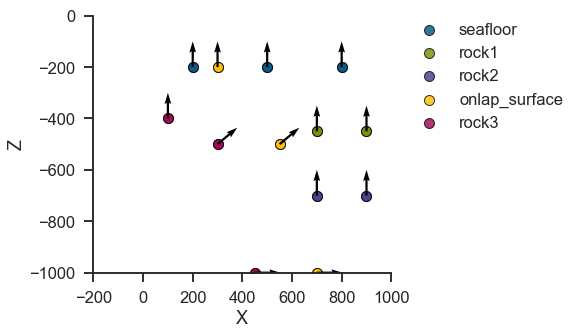

In [6]:
gp.plot.plot_data(geo_model, direction='y')

In [7]:
gp.set_interpolation_data(geo_model, verbose=[])

Compiling theano function...
Compilation Done!


In [8]:
geo_model.set_regular_grid([-200,1000,-500,500,-1000,0], [100,100,100])

Active grids: ['regular']


Grid Object. Values: 
array([[-194., -495., -995.],
       [-194., -495., -985.],
       [-194., -495., -975.],
       ...,
       [ 994.,  495.,  -25.],
       [ 994.,  495.,  -15.],
       [ 994.,  495.,   -5.]])

In [ ]:
gp.compute_model(geo_model, compute_mesh=True)

In [ ]:
geo_model.solutions.compute_all_surfaces();

In [ ]:
geo_model.solutions.scalar_field_at_surface_points

In [ ]:
gp.plot.plot_section(geo_model, 2, block=geo_model.solutions.lith_block, show_data=True)

## Marching cubes explanation.

The geological model above is done ovelying several fields. This is a common geometry in geological models due to tectonics and similar effects over the history of a region.

In [ ]:
# Example of block of rock1 and rock 2
gp.plot.plot_section(geo_model, 2, block=geo_model.solutions.block_matrix[1], show_data=True)

In [ ]:
# Example of block for onlap surface
gp.plot.plot_section(geo_model, 20, block=geo_model.solutions.block_matrix[2], show_data=True)

This discretizations are coming for an interpolated scalar field:

In [ ]:
# Example of scalar field of rock1 and rock 2
gp.plot.plot_scalar_field(geo_model, 25, series=1)
plt.colorbar()

In [ ]:
# Example of scalar field of onlap series
gp.plot.plot_scalar_field(geo_model, 25, series=2)
plt.colorbar()

The way to overlap this different fields is given by boolean matrices that encode their stratigraphic relations:

In [ ]:
# Example of block of rock1 and rock 2
plt.imshow(geo_model.solutions.mask_matrix[1].reshape(100,100,100)[:,20,:].T, origin='bottom')

In [ ]:
# Example of onlap
plt.imshow(geo_model.solutions.mask_matrix[3].reshape(100,100,100)[:,20,:].T, origin='bottom')

But actually this boolean arrays are within the volume! The surfaces where we want to perform the marching cube are at the interfaces of the boolean arrays. To do so we add some padding:

In [ ]:
#geo_model.solutions.padding_mask_matrix()

In [ ]:
from gempy.utils.input_manipulation import find_interfaces_from_block_bottoms

# Example of block of rock1 and rock 2
mp1 = find_interfaces_from_block_bottoms(geo_model.solutions.mask_matrix[1].reshape(100,100,100), True)

plt.imshow(mp1[:,20,:].T, origin='bottom')

In [ ]:
# Example of block of rock1 and rock 2
mp2 = find_interfaces_from_block_bottoms(geo_model.solutions.mask_matrix[3].reshape(100,100,100), True)

plt.imshow(mp2[:,20,:].T, origin='bottom')

### Performing marching cubes

Now lets go back to the original model. For this example lets forcus on the green, purple and magenta surfaces:

In [ ]:
gp.plot.plot_section(geo_model, 2, block=geo_model.solutions.lith_block, show_data=True)

If we just perform the marching cube in the scalar fields we saw above the mesh will be continuos:

#### Classic marching cubes

In [ ]:
from skimage import measure

scalar_field = geo_model.solutions.scalar_field_matrix
level = geo_model.solutions.scalar_field_at_surface_points

v0, s0, normals, values = measure.marching_cubes_lewiner(
    scalar_field[0].reshape(geo_model.grid.regular_grid.resolution[0],
                         geo_model.grid.regular_grid.resolution[1],
                         geo_model.grid.regular_grid.resolution[2]),
    level[0,0],
    spacing=geo_model.grid.regular_grid.get_dx_dy_dz(),
    mask=None,
)


v1, s1, normals, values = measure.marching_cubes_lewiner(
    scalar_field[1].reshape(geo_model.grid.regular_grid.resolution[0],
                         geo_model.grid.regular_grid.resolution[1],
                         geo_model.grid.regular_grid.resolution[2]),
    level[1,1],
    spacing=geo_model.grid.regular_grid.get_dx_dy_dz(),
    mask=None,
)

v2, s2, normals, values = measure.marching_cubes_lewiner(
    scalar_field[1].reshape(geo_model.grid.regular_grid.resolution[0],
                         geo_model.grid.regular_grid.resolution[1],
                         geo_model.grid.regular_grid.resolution[2]),
    level[1,2],
    spacing=geo_model.grid.regular_grid.get_dx_dy_dz(),
    mask=None,
)

v3, s3, normals, values = measure.marching_cubes_lewiner(
    scalar_field[3].reshape(geo_model.grid.regular_grid.resolution[0],
                         geo_model.grid.regular_grid.resolution[1],
                         geo_model.grid.regular_grid.resolution[2]),
    level[2, 3],
    spacing=geo_model.grid.regular_grid.get_dx_dy_dz(),
    mask=None,
)

v4, s4, normals, values = measure.marching_cubes_lewiner(
    scalar_field[3].reshape(geo_model.grid.regular_grid.resolution[0],
                         geo_model.grid.regular_grid.resolution[1],
                         geo_model.grid.regular_grid.resolution[2]),
    level[3, 4],
    spacing=geo_model.grid.regular_grid.get_dx_dy_dz(),
    mask=None,
)


In [ ]:
fig = gp.plot.ipyvolumeVisualization(geo_model)
fig.plot_surfaces()

![foo2](../data/figures/ipv.png)

However what we want is that the layers end in the other layers:

#### Masked marching cubes

In [ ]:
from skimage import measure

scalar_field = geo_model.solutions.scalar_field_matrix
level = geo_model.solutions.scalar_field_at_surface_points

v0, s0, normals, values = measure.marching_cubes_lewiner(
    scalar_field[0].reshape(geo_model.grid.regular_grid.resolution[0],
                            geo_model.grid.regular_grid.resolution[1],
                            geo_model.grid.regular_grid.resolution[2]),
    level[0,0],
    spacing=geo_model.grid.regular_grid.get_dx_dy_dz(),
    mask=geo_model.solutions.mask_matrix_pad[0],
)

v1, s1, normals, values = measure.marching_cubes_lewiner(
    scalar_field[1].reshape(geo_model.grid.regular_grid.resolution[0],
                            geo_model.grid.regular_grid.resolution[1],
                            geo_model.grid.regular_grid.resolution[2]),
    level[1,1],
    spacing=geo_model.grid.regular_grid.get_dx_dy_dz(),
    mask=geo_model.solutions.mask_matrix_pad[1],
)

v2, s2, normals, values = measure.marching_cubes_lewiner(
    scalar_field[1].reshape(geo_model.grid.regular_grid.resolution[0],
                            geo_model.grid.regular_grid.resolution[1],
                            geo_model.grid.regular_grid.resolution[2]),
    level[1,2],
    spacing=geo_model.grid.regular_grid.get_dx_dy_dz(),
    mask=geo_model.solutions.mask_matrix_pad[1],
)

v3, s3, normals, values = measure.marching_cubes_lewiner(
    scalar_field[2].reshape(geo_model.grid.regular_grid.resolution[0],
                            geo_model.grid.regular_grid.resolution[1],
                            geo_model.grid.regular_grid.resolution[2]),
    level[2, 3],
    spacing=geo_model.grid.regular_grid.get_dx_dy_dz(),
    mask=geo_model.solutions.mask_matrix_pad[3],
)

v4, s4, normals, values = measure.marching_cubes_lewiner(
    scalar_field[3].reshape(geo_model.grid.regular_grid.resolution[0],
                            geo_model.grid.regular_grid.resolution[1],
                            geo_model.grid.regular_grid.resolution[2]),
    level[3, 4],
    spacing=geo_model.grid.regular_grid.get_dx_dy_dz(),
    mask=geo_model.solutions.mask_matrix_pad[3],
)



In [ ]:
fig = gp.plot.ipyvolumeVisualization(geo_model)
fig.plot_surfaces()

![foo](../data/figures/ipyvolume.png)


###  Speed comparison

#### Original

In [ ]:
scalar_field = geo_model.solutions.scalar_field_matrix
level = geo_model.solutions.scalar_field_at_surface_points

v0, s0, normals, values = measure.marching_cubes_lewiner(
    scalar_field[0].reshape(geo_model.grid.regular_grid.resolution[0],
                            geo_model.grid.regular_grid.resolution[1],
                            geo_model.grid.regular_grid.resolution[2]),
    level[0,0],
    spacing=geo_model.grid.regular_grid.get_dx_dy_dz(),
    mask=None,
)


v1, s1, normals, values = measure.marching_cubes_lewiner(
    scalar_field[1].reshape(geo_model.grid.regular_grid.resolution[0],
                            geo_model.grid.regular_grid.resolution[1],
                            geo_model.grid.regular_grid.resolution[2]),
    level[1,1],
    spacing=geo_model.grid.regular_grid.get_dx_dy_dz(),
    mask=None,
)

v2, s2, normals, values = measure.marching_cubes_lewiner(
    scalar_field[1].reshape(geo_model.grid.regular_grid.resolution[0],
                            geo_model.grid.regular_grid.resolution[1],
                            geo_model.grid.regular_grid.resolution[2]),
    level[1,2],
    spacing=geo_model.grid.regular_grid.get_dx_dy_dz(),
    mask=None,
)

v3, s3, normals, values = measure.marching_cubes_lewiner(
    scalar_field[3].reshape(geo_model.grid.regular_grid.resolution[0],
                            geo_model.grid.regular_grid.resolution[1],
                            geo_model.grid.regular_grid.resolution[2]),
    level[2, 3],
    spacing=geo_model.grid.regular_grid.get_dx_dy_dz(),
    mask=None,
)

v4, s4, normals, values = measure.marching_cubes_lewiner(
    scalar_field[3].reshape(geo_model.grid.regular_grid.resolution[0],
                            geo_model.grid.regular_grid.resolution[1],
                            geo_model.grid.regular_grid.resolution[2]),
    level[3, 4],
    spacing=geo_model.grid.regular_grid.get_dx_dy_dz(),
    mask=None,
)

#### Masked

In [ ]:
%%timeit
scalar_field = geo_model.solutions.scalar_field_matrix
level = geo_model.solutions.scalar_field_at_surface_points

v0, s0, normals, values = measure.marching_cubes_lewiner(
    scalar_field[0].reshape(geo_model.grid.regular_grid.resolution[0],
                            geo_model.grid.regular_grid.resolution[1],
                            geo_model.grid.regular_grid.resolution[2]),
    level[0,0],
    spacing=geo_model.grid.regular_grid.get_dx_dy_dz(),
    mask=geo_model.solutions.mask_matrix_pad[0],
)

v1, s1, normals, values = measure.marching_cubes_lewiner(
    scalar_field[1].reshape(geo_model.grid.regular_grid.resolution[0],
                            geo_model.grid.regular_grid.resolution[1],
                            geo_model.grid.regular_grid.resolution[2]),
    level[1,1],
    spacing=geo_model.grid.regular_grid.get_dx_dy_dz(),
    mask=geo_model.solutions.mask_matrix_pad[1],
)

v2, s2, normals, values = measure.marching_cubes_lewiner(
    scalar_field[1].reshape(geo_model.grid.regular_grid.resolution[0],
                            geo_model.grid.regular_grid.resolution[1],
                            geo_model.grid.regular_grid.resolution[2]),
    level[1,2],
    spacing=geo_model.grid.regular_grid.get_dx_dy_dz(),
    mask=geo_model.solutions.mask_matrix_pad[1],
)

v3, s3, normals, values = measure.marching_cubes_lewiner(
    scalar_field[2].reshape(geo_model.grid.regular_grid.resolution[0],
                            geo_model.grid.regular_grid.resolution[1],
                            geo_model.grid.regular_grid.resolution[2]),
    level[2, 3],
    spacing=geo_model.grid.regular_grid.get_dx_dy_dz(),
    mask=geo_model.solutions.mask_matrix_pad[3],
)

v4, s4, normals, values = measure.marching_cubes_lewiner(
    scalar_field[3].reshape(geo_model.grid.regular_grid.resolution[0],
                            geo_model.grid.regular_grid.resolution[1],
                            geo_model.grid.regular_grid.resolution[2]),
    level[3, 4],
    spacing=geo_model.grid.regular_grid.get_dx_dy_dz(),
    mask=geo_model.solutions.mask_matrix_pad[3],
)


In [ ]:
# Number of Trues
print(geo_model.solutions.mask_matrix_pad[0].sum(), geo_model.solutions.mask_matrix_pad[0].sum()/1e4,'%')
print(geo_model.solutions.mask_matrix_pad[1].sum(), geo_model.solutions.mask_matrix_pad[1].sum()/1e4,'%')
print(geo_model.solutions.mask_matrix_pad[3].sum(), geo_model.solutions.mask_matrix_pad[3].sum()/1e4,'%')

#### Masked all True

But if we make the masking all Trues it takes a bit longer than just calling the unmodified function (which we do when we pass None). (Not in my new laptop apparently)

In [ ]:
%%timeit
scalar_field = geo_model.solutions.scalar_field_matrix
level = geo_model.solutions.scalar_field_at_surface_points

v0, s0, normals, values = measure.marching_cubes_lewiner(
    scalar_field[0].reshape(geo_model.grid.regular_grid.resolution[0],
                            geo_model.grid.regular_grid.resolution[1],
                            geo_model.grid.regular_grid.resolution[2]),
    level[0,0],
    spacing=geo_model.grid.regular_grid.get_dx_dy_dz(),
    mask=np.ones_like(geo_model.solutions.mask_matrix_pad[0]),
)

v1, s1, normals, values = measure.marching_cubes_lewiner(
    scalar_field[1].reshape(geo_model.grid.regular_grid.resolution[0],
                            geo_model.grid.regular_grid.resolution[1],
                            geo_model.grid.regular_grid.resolution[2]),
    level[1,1],
    spacing=geo_model.grid.regular_grid.get_dx_dy_dz(),
    mask=np.ones_like(geo_model.solutions.mask_matrix_pad[0]),
)

v2, s2, normals, values = measure.marching_cubes_lewiner(
    scalar_field[1].reshape(geo_model.grid.regular_grid.resolution[0],
                            geo_model.grid.regular_grid.resolution[1],
                            geo_model.grid.regular_grid.resolution[2]),
    level[1,2],
    spacing=geo_model.grid.regular_grid.get_dx_dy_dz(),
    mask=np.ones_like(geo_model.solutions.mask_matrix_pad[0]),
)

v3, s3, normals, values = measure.marching_cubes_lewiner(
    scalar_field[2].reshape(geo_model.grid.regular_grid.resolution[0],
                            geo_model.grid.regular_grid.resolution[1],
                            geo_model.grid.regular_grid.resolution[2]),
    level[2, 3],
    spacing=geo_model.grid.regular_grid.get_dx_dy_dz(),
    mask=np.ones_like(geo_model.solutions.mask_matrix_pad[0]),
)

v4, s4, normals, values = measure.marching_cubes_lewiner(
    scalar_field[3].reshape(geo_model.grid.regular_grid.resolution[0],
                            geo_model.grid.regular_grid.resolution[1],
                            geo_model.grid.regular_grid.resolution[2]),
    level[3, 4],
    spacing=geo_model.grid.regular_grid.get_dx_dy_dz(),
    mask=np.ones_like(geo_model.solutions.mask_matrix_pad[0]),
)


In [ ]:
gp.plot.plot_3D(geo_model)

Update if any changes were made:

In [ ]:
#geo_model.update_to_interpolator()
#gp.compute_model(geo_model, compute_mesh=False)

Save model if any changes were made:

In [ ]:
#geo_model.save_model('Tutorial_ch1-8_Onlap_relations')